# Create label of facade = 1/0
### Used to classify pictures as actually looking at a facade or not

### Set up

In [1]:
import os
import sys
import re
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import numpy as np

# Set up dirs for jupyter notebook using cwd
dir_name = 'PGHComputerVision'
root = os.getcwd()
# sub out any text after dir_name to get project directory
root = re.sub(rf"{dir_name}.*", dir_name, root)

# create code and data directories
code_root = os.path.join(root, 'Code')
data_root = os.path.join(root, 'Data')

# Read in helper function
sys.path.append( os.path.join(code_root, 'helpers') )
from read_in_PGH_shp_files import load_pgh_shp_files


In [2]:
# Read in geodf of Pittsburgh neighborhoods
gdf_pics_path = os.path.join(data_root, 'GSV', 'Res_640', 'in_downtown', 'downtown_shpfiles', 'downtown_images.shp')

# Read in shapefile to geodf
gdf_pics = gpd.read_file(gdf_pics_path)

gdf_pics.head()


,segment_id,filename,image_pano,date,query_coun,lat,lon,years_sinc,name,length,bearing,geometry
0,684842474-684842485,img_684842474-684842485_h1_016.png,kZ_z5uRYioemWEf6Vp3w2w,2023-12-01,39.0,40.441075,-79.992610,0.30,NA,122.110,91.2,POINT (409760.864 125413.759)
1,104572699-104573441,img_104572699-104573441_h0_004.png,ZiqppgAxP4ip184aU7A_7Q,2022-10-01,20.0,40.439209,-79.994567,1.47,Sixth Avenue,117.064,199.9,POINT (409589.664 125210.800)
2,104572699-104573441,img_104572699-104573441_h1_005.png,ZiqppgAxP4ip184aU7A_7Q,2022-10-01,21.0,40.439209,-79.994567,1.47,Sixth Avenue,117.064,199.9,POINT (409589.664 125210.800)
3,104572699-104573441,img_104572699-104573441_h1_003.png,v240jYlNDJUxJnT_1s5D2A,2022-10-01,5.0,40.439474,-79.994401,1.47,Sixth Avenue,117.064,199.9,POINT (409604.444 125239.857)
4,104572699-104573441,img_104572699-104573441_h0_002.png,v240jYlNDJUxJnT_1s5D2A,2022-10-01,4.0,40.439474,-79.994401,1.47,Sixth Avenue,117.064,199.9,POINT (409604.444 125239.857)


In [3]:
# Look for file facade_labels.csv, load if it exists, create df if not
facade_labels_path = os.path.join(data_root, 'GSV', 'Res_640', 'in_downtown', 'facade_labels.csv')
if os.path.exists(facade_labels_path):
    labels_df = pd.read_csv(facade_labels_path)
else:
    # create new df with segment_id, filename, and "facade_label" initialized to nan
    labels_df = pd.DataFrame(gdf_pics[['segment_id', 'filename']]).copy()
    labels_df['facade_label'] = np.nan
    labels_df['ortho_to_street'] = np.nan
    # save
    labels_df.to_csv(facade_labels_path, index=False)
    
print(f" Num missing labels: {labels_df['facade_label'].isna().sum()}")
print(f" Num labeled: {labels_df['facade_label'].notna().sum()}")
labels_df.head()


 Num missing labels: 3468
 Num labeled: 220


,segment_id,filename,facade_label,ortho_to_street
0,684842474-684842485,img_684842474-684842485_h1_016.png,0.5,0.0
1,104572699-104573441,img_104572699-104573441_h0_004.png,1.0,1.0
2,104572699-104573441,img_104572699-104573441_h1_005.png,1.0,1.0
3,104572699-104573441,img_104572699-104573441_h1_003.png,1.0,1.0
4,104572699-104573441,img_104572699-104573441_h0_002.png,1.0,1.0


In [4]:
def label_facade(facade_labels_path, im_dir = os.path.join(data_root, 'GSV', 'Res_640', 'in_downtown') ):

    labels_df = pd.read_csv(facade_labels_path)

    # Get indices of images that have not been labeled
    unlabeled = labels_df[labels_df['facade_label'].isna()].index
    # convert to list
    unlabeled = list(unlabeled)
    # shuffle list
    np.random.shuffle(unlabeled)

    # Loop through 10 unlabeled images, displaying each image and asking for input
    for i in unlabeled[:10]:
        # Display image
        print(gdf_pics.iloc[i]['filename'])
        img = plt.imread( os.path.join(im_dir, gdf_pics.iloc[i]['filename']) )
        plt.imshow(img)
        plt.show()

        # Ask for input
        facade_label = input('Enter facade label: 0 (down street), .5 (partial on facade), 1 (on facade): ')
        # check for value being 0, .5 or 1 and ask for input again if not
        while facade_label not in ['0', '.5', '1']:
            facade_label = input('Enter facade label: 0 (not a facade), .5 (partial facade), 1 (facade): ')

        # Save input to df
        labels_df.loc[i, 'facade_label'] = float( facade_label)

        # ask for downstreet label
        downstreet_label = input('Enter ortho_to_street label: 0 (looks downstreet), 1 (ortho) , .5(halfway): ')
        # check for value being 0, .5 or 1 and ask for input again if not
        while downstreet_label not in ['0', '.5', '1']:
            downstreet_label = input('Enter ortho_to_street label: 0 (looks downstreet), 1 (ortho) , .5(halfway): ')
        labels_df.loc[i, 'ortho_to_street'] = float(downstreet_label)

    # Save df to csv
    labels_df.to_csv(facade_labels_path, index=False)
    print('Saved')

    # ask if user wants to label more images
    more = input('Label more images? (y/n): ')
    if more == 'y':
        label_facade(facade_labels_path)
    else:
        return
    

In [ ]:
# Run function to label facades
label_facade(facade_labels_path)

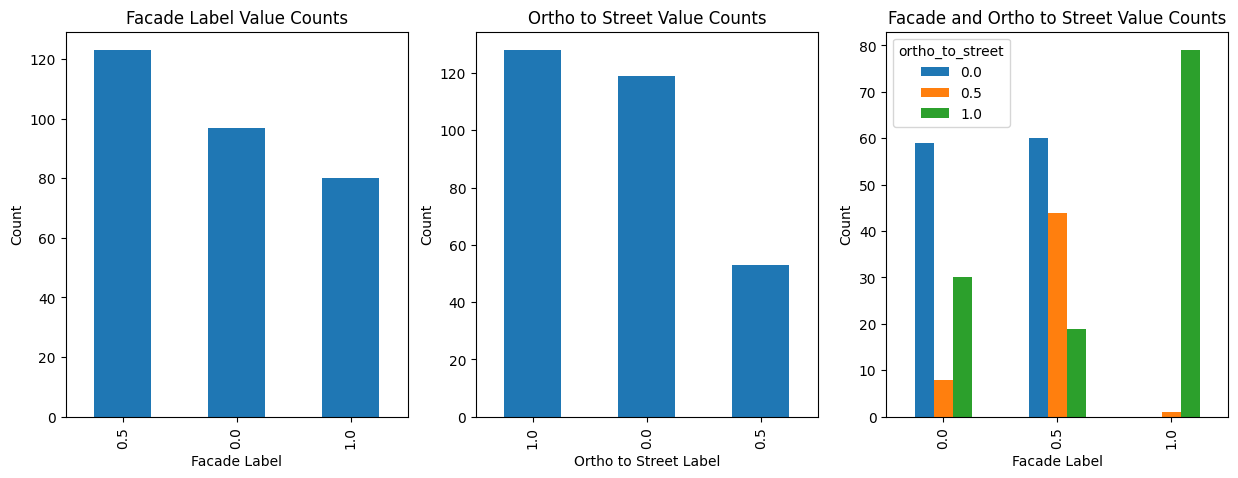

In [9]:
# subplots: value counts of facade_label, value counts of ortho_to_street, and both
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

labels_df['facade_label'].value_counts().plot(kind='bar', ax=ax[0])

ax[0].set_title('Facade Label Value Counts')
ax[0].set_xlabel('Facade Label')
ax[0].set_ylabel('Count')

labels_df['ortho_to_street'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].set_title('Ortho to Street Value Counts')
ax[1].set_xlabel('Ortho to Street Label')
ax[1].set_ylabel('Count')

labels_df.groupby(['facade_label', 'ortho_to_street']).size().unstack().plot(kind='bar', ax=ax[2])
ax[2].set_title('Facade and Ortho to Street Value Counts')
ax[2].set_xlabel('Facade Label')
ax[2].set_ylabel('Count')
plt.show()




In [8]:
labels_df = pd.read_csv(facade_labels_path)
print(f" Num missing labels: {labels_df['facade_label'].isna().sum()}")
print(f" Num labeled: {labels_df['facade_label'].notna().sum()}")
labels_df.head()

 Num missing labels: 3388
 Num labeled: 300


,segment_id,filename,facade_label,ortho_to_street
0,684842474-684842485,img_684842474-684842485_h1_016.png,0.5,0.0
1,104572699-104573441,img_104572699-104573441_h0_004.png,1.0,1.0
2,104572699-104573441,img_104572699-104573441_h1_005.png,1.0,1.0
3,104572699-104573441,img_104572699-104573441_h1_003.png,1.0,1.0
4,104572699-104573441,img_104572699-104573441_h0_002.png,1.0,1.0
